# Run Simulations

## Import relevant libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from configparser import ConfigParser

import gym
import gym_anytrading

from gym_anytrading.envs import CryptoEnvLogBLSH

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

## Get values from the config file

In [2]:
configur = ConfigParser()
config_file_name = "config_04.ini"
print (configur.read(os.path.join('config_files', config_file_name)))

['config_files/config_02.ini']


In [3]:
ccy = configur.get('data', 'ccy')
data_frequency = configur.get('data', 'data_frequency')

window_size = configur.getint('dates', 'window_size')
start_date = configur.get('dates', 'start_date')
mid_date = configur.get('dates', 'mid_date')
end_date = configur.get('dates', 'end_date')

list_features = configur.get('features', 'features').split(',')

model_type = configur.get('model', 'model_type')

num_of_simulations = configur.getint('simulation', 'num_of_simulations')

In [4]:
# print(ccy)
# print(data_frequency)

# print(window_size)
# print(start_date)
# print(mid_date)
# print(end_date)

# print(list_features)

# print(model_type)

# print(num_of_simulations)

In [5]:
def get_and_process_data(ccy, data_frequency):
    try:
        
        # Get the data
        filename_data = 'binance_' + ccy + "_" + data_frequency + '_from_2020_01_01_to_2022_09_30_candlesticks_signals_processed_technical_indicators_and_crypto_index.csv'
        fullpath_data = os.path.join('../../data', filename_data)
        df = pd.read_csv(fullpath_data)

        # Converting Date Column to DateTime Type
        df['Date'] = pd.to_datetime(df['formatted_open_time'])

        # Setting the column as index
        df.set_index('Date', inplace=True)

        return df

    except Exception as e:
        print(e)

In [6]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, list_features].to_numpy()[start:end]
    return prices, signal_features

class MyEnv(CryptoEnvLogBLSH):
    _process_data = my_process_data

In [7]:
df = get_and_process_data(ccy, data_frequency)

In [8]:
start_date_id = int(df.index.get_loc(start_date))
mid_date_id = int(df.index.get_loc(mid_date))
end_date_id = int(df.index.get_loc(end_date))

In [9]:
#setting up our environment for training 
env_maker = lambda: MyEnv(df=df, frame_bound=(start_date_id,mid_date_id), window_size=window_size)
env = DummyVecEnv([env_maker])

if(model_type == 'A2C'):
    model = A2C('MlpPolicy', env, verbose=1) 
elif(model_type == 'PPO'):
    model = PPO('MlpPolicy', env, verbose=1)
elif(model_type == 'DQN'):
    model = DQN('MlpPolicy', env, verbose=1)

#setting the learning timesteps
model.learn(total_timesteps=(mid_date_id - start_date_id))  

Using cpu device


In [10]:
df_sim_results = pd.DataFrame(columns=['total_reward_cash', 'total_profit_percentage', 'num_of_trades'])

In [11]:
for i in range(num_of_simulations):   

    env = MyEnv(df=df, frame_bound=(mid_date_id,end_date_id), window_size=window_size)
    #Setting up the Agent Environment
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            #print("info", info)
            df_sim_results = df_sim_results.append(info, ignore_index=True, sort=False)
            break       

## Results Analysis

In [12]:
df_sim_results.describe()

,total_reward_cash,total_profit_percentage,num_of_trades
count,1000.000000,1000.000000,1000.000000
mean,-496.463420,0.503537,49.997000
std,99.814236,0.099814,6.797146
min,-701.289408,0.298711,29.000000
25%,-567.156922,0.432843,45.000000
50%,-511.839927,0.488160,50.000000
75%,-438.923255,0.561077,54.000000
max,-67.853088,0.932147,69.000000


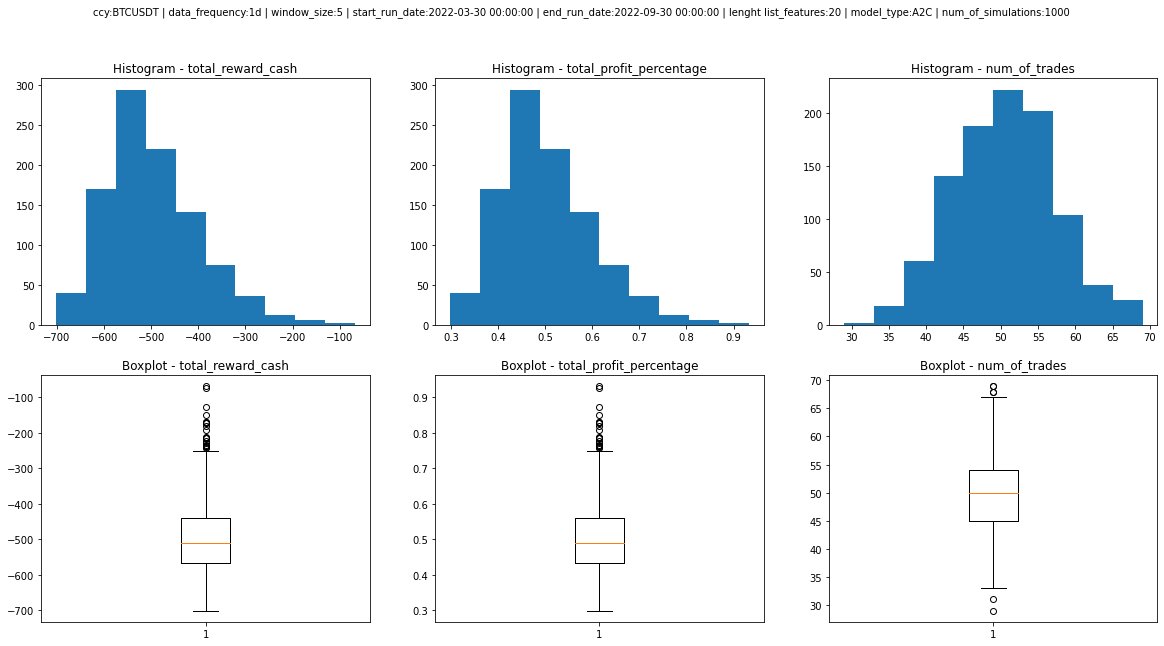

In [13]:
# Creating histogram
figure, axis = plt.subplots(2, 3, figsize=(20,10))

figure.suptitle(f'ccy:{ccy} | data_frequency:{data_frequency} | window_size:{window_size} | start_run_date:{mid_date} | end_run_date:{end_date} | lenght list_features:{len(list_features)} | model_type:{model_type} | num_of_simulations:{num_of_simulations}', fontsize=10)

axis[0, 0].hist(df_sim_results.total_reward_cash)
axis[0, 0].set_title("Histogram - total_reward_cash")

axis[0, 1].hist(df_sim_results.total_profit_percentage)
axis[0, 1].set_title("Histogram - total_profit_percentage")

axis[0, 2].hist(df_sim_results.num_of_trades)
axis[0, 2].set_title("Histogram - num_of_trades")

axis[1, 0].boxplot(df_sim_results.total_reward_cash)
axis[1, 0].set_title("Boxplot - total_reward_cash")

axis[1, 1].boxplot(df_sim_results.total_profit_percentage)
axis[1, 1].set_title("Boxplot - total_profit_percentage")

axis[1, 2].boxplot(df_sim_results.num_of_trades)
axis[1, 2].set_title("Boxplot - num_of_trades")

# Show plot
plt.show()

file_export_sim_results_plot = config_file_name.replace(".ini", ".png")
fullpath_export_sim_results_plot = os.path.join('results', file_export_sim_results_plot)

figure.savefig(fullpath_export_sim_results_plot)

## Export results

In [14]:
file_export_sim_results = config_file_name.replace(".ini", ".csv")
fullpath_export_sim_results = os.path.join('results', file_export_sim_results)

### Add config info

In [15]:
df_sim_results['ccy'] = ccy
df_sim_results['data_frequency'] = data_frequency
df_sim_results['window_size'] = window_size
df_sim_results['start_date'] = start_date
df_sim_results['mid_date'] = mid_date
df_sim_results['end_date'] = end_date
df_sim_results['list_features'] = str(list_features)
df_sim_results['model_type'] = model_type
df_sim_results['num_of_simulations'] = num_of_simulations

In [16]:
df_sim_results.to_csv(fullpath_export_sim_results)